# Importing The Data

In [1]:
#Let's start by bringing in the data

In [163]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('online_retail_II_1.csv')

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


In [5]:
#Let's check the datatypes

In [6]:
df.dtypes

Invoice         object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
Price          float64
Customer ID    float64
Country         object
dtype: object

In [7]:
#The columns are mostly correct, except that customer id is a float, when it should be a string
#Secondly, InvoiceDate should be a datetime column

In [8]:
df['Customer ID'] = df['Customer ID'].astype('str')

In [9]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID            object
Country                object
dtype: object

In [11]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [12]:
#Now our data types are as we excepted

# Cleaning The Data

In [13]:
#We know that any invoice that starts with 'C' is a cancellation, so let's indicate this in the table

In [14]:
df['is_cancel'] = df['Invoice'].apply(lambda x: 1 if 'C' in x else 0)

In [15]:
#Let's confirm that we have correctly identified cancelled orders

In [16]:
df[df['is_cancel'] == 1].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,1
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia,1
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia,1
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia,1
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia,1


In [17]:
#So we want to segment the customers in this dataset to identify profitable customers to target
#A few features we can segment on:

#Avg Quantity
#Avg revenue per order
#Number of orders
#% of orders cancelled

In [18]:
#More ideas can come about as we create our dataset, but we can start with these for now

In [19]:
#Before we group by customer, we need to adjust the the quantities for cancelled orders
#They're negative, which makes me think that in the dataset, a cancelled invoice shows up twice
#One for the initil order, and another to indicate it was cancelled

In [20]:
df[df['Invoice'] == '489449']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel


In [21]:
#I was wrong, but I still don't want negative quantities when taking an avg
#This should be 0 since there isn't the initial order to cancel out the negative quantities if we take the mean

In [22]:
df['Quantity'] = np.where(df['Quantity'] < 0, 0, df['Quantity'])

In [23]:
#Lets check one of the cancelled order

df[df['Invoice'] == 'C489449']

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel
178,C489449,22087,PAPER BUNTING WHITE LACE,0,2009-12-01 10:33:00,2.95,16321.0,Australia,1
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,0,2009-12-01 10:33:00,1.65,16321.0,Australia,1
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,0,2009-12-01 10:33:00,4.25,16321.0,Australia,1
181,C489449,21896,POTTING SHED TWINE,0,2009-12-01 10:33:00,2.10,16321.0,Australia,1
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,0,2009-12-01 10:33:00,2.95,16321.0,Australia,1
183,C489449,21871,SAVE THE PLANET MUG,0,2009-12-01 10:33:00,1.25,16321.0,Australia,1
184,C489449,84946,ANTIQUE SILVER TEA GLASS ETCHED,0,2009-12-01 10:33:00,1.25,16321.0,Australia,1
185,C489449,84970S,HANGING HEART ZINC T-LIGHT HOLDER,0,2009-12-01 10:33:00,0.85,16321.0,Australia,1
186,C489449,22090,PAPER BUNTING RETRO SPOTS,0,2009-12-01 10:33:00,2.95,16321.0,Australia,1


In [24]:
#Great, so the quantity is 0, which makes sense since the sale never occured due to the cancellation

In [25]:
#Do we have orders with a price of 0

df[df['Price'] == 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel
263,489464,21733,85123a mixed,0,2009-12-01 10:52:00,0.0,nan,United Kingdom,0
283,489463,71477,short,0,2009-12-01 10:52:00,0.0,nan,United Kingdom,0
284,489467,85123A,21733 mixed,0,2009-12-01 10:53:00,0.0,nan,United Kingdom,0
470,489521,21646,NaN,0,2009-12-01 11:44:00,0.0,nan,United Kingdom,0
3114,489655,20683,NaN,0,2009-12-01 17:26:00,0.0,nan,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,0,2010-12-09 17:17:00,0.0,nan,United Kingdom,0
525232,538158,20892,NaN,0,2010-12-09 17:17:00,0.0,nan,United Kingdom,0
525233,538160,20956,NaN,288,2010-12-09 17:18:00,0.0,nan,United Kingdom,0
525234,538161,46000S,Dotcom sales,0,2010-12-09 17:25:00,0.0,nan,United Kingdom,0


In [26]:
#Looks like we have random orders with no description, no price/quantity, nor a customer id
#I'll remove any purchase w/o customer id

In [27]:
df = df[df['Customer ID'] != 'nan']

In [28]:
#Let's check the 0 Price is only for cancelled orders

df[df['Price'] == 0]['is_cancel'].unique()

array([0])

In [29]:
df[(df['Price'] == 0) & (df['is_cancel'] == 0)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel
4674,489825,22076,6 RIBBONS EMPIRE,12,2009-12-02 13:34:00,0.0,16126.0,United Kingdom,0
6781,489998,48185,DOOR MAT FAIRY CAKE,2,2009-12-03 11:19:00,0.0,15658.0,United Kingdom,0
16107,490727,M,Manual,1,2009-12-07 16:38:00,0.0,17231.0,United Kingdom,0
18738,490961,22065,CHRISTMAS PUDDING TRINKET POT,1,2009-12-08 15:25:00,0.0,14108.0,United Kingdom,0
18739,490961,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-08 15:25:00,0.0,14108.0,United Kingdom,0
32916,492079,85042,ANTIQUE LILY FAIRY LIGHTS,8,2009-12-15 13:49:00,0.0,15070.0,United Kingdom,0
40101,492760,21143,ANTIQUE GLASS HEART DECORATION,12,2009-12-18 14:22:00,0.0,18071.0,United Kingdom,0
47126,493761,79320,FLAMINGO LIGHTS,24,2010-01-06 14:54:00,0.0,14258.0,United Kingdom,0
48342,493899,22355,"CHARLOTTE BAG , SUKI DESIGN",10,2010-01-08 10:43:00,0.0,12417.0,Belgium,0
57619,494607,21533,RETRO SPOT LARGE MILK JUG,12,2010-01-15 12:43:00,0.0,16858.0,United Kingdom,0


In [30]:
#Why do we have orders where items were 0?

In [31]:
#I'm concerned there may be a data issue where perhaps the price didn't flow to some of these purchases
#Let's confirm this by grouping by stockcode and get the min, median, and max price
#If all 3 are the same, then we know the 0 price is correct
#If any are different, then we know that these 0 prices are incorrect as other orders have a price for the product

In [32]:
products = df.groupby('StockCode').agg({'Price': ['min', 'median', 'max']})

In [33]:
products = products.droplevel(0,axis=1)

In [34]:
products.head()

,min,median,max
StockCode,,,
10002,0.72,0.85,0.85
10080,0.85,0.85,0.85
10109,0.42,0.42,0.42
10120,0.21,0.21,0.21
10123C,0.06,0.65,0.65


In [35]:
#Some items could have been on sale, so different prices is fine
#But any where the min 0 and median/max is something else would raise a red flag

In [36]:
products_0 = products[products['min'] == 0]
products_0

,min,median,max
StockCode,,,
20914,0.0,2.95,2.95
21143,0.0,1.95,1.95
21533,0.0,4.95,4.95
21662,0.0,5.95,5.95
21765,0.0,7.95,7.95
21843,0.0,10.95,10.95
22065,0.0,1.45,1.45
22076,0.0,1.65,1.65
22121,0.0,5.95,6.54


In [37]:
#These items seem to have been mis-priced in some orders, so let's join this back to the original table
#Then we 'll set a correct price

In [38]:
#This price seems absurdly high

df[df['Price'] == 25111.09]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel
241824,C512770,M,Manual,0,2010-06-17 16:52:00,25111.09,17399.0,United Kingdom,1


In [39]:
#The order was cancelled so I'll leave it since it won't mess with revenue numbers

In [40]:
df = df.merge(products_0, on='StockCode')

In [41]:
#Now, for any price that is equal to 0, change the price to the max column

In [42]:
df['Price'] = np.where(df['Price'] == 0, df['median'], df['Price'])

In [43]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel,min,median,max
0,489436,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-01 09:06:00,1.45,13078.0,United Kingdom,0,0.0,1.45,1.45
1,489536,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 12:13:00,1.45,16393.0,United Kingdom,0,0.0,1.45,1.45
2,489536,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 12:13:00,1.45,16393.0,United Kingdom,0,0.0,1.45,1.45
3,489536,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 12:13:00,1.45,16393.0,United Kingdom,0,0.0,1.45,1.45
4,489562,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 13:07:00,1.45,17998.0,United Kingdom,0,0.0,1.45,1.45


In [44]:
#Lets confirm there are no more 0 prices

In [45]:
df[df['Price'] == 0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel,min,median,max


In [46]:
#Now we can create a revenue column, which we'll also segment by

In [47]:
df['Revenue'] = df['Quantity'] * df['Price']

In [48]:
#Lets drop the min/median/max columns

df = df.drop(['min', 'median', 'max'], axis=1)

In [49]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel,Revenue
0,489436,22142,CHRISTMAS CRAFT WHITE FAIRY,12,2009-12-01 09:06:00,1.45,13078.0,United Kingdom,0,17.40
1,489536,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 12:13:00,1.45,16393.0,United Kingdom,0,1.45
2,489536,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 12:13:00,1.45,16393.0,United Kingdom,0,1.45
3,489536,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 12:13:00,1.45,16393.0,United Kingdom,0,1.45
4,489562,22142,CHRISTMAS CRAFT WHITE FAIRY,1,2009-12-01 13:07:00,1.45,17998.0,United Kingdom,0,1.45


In [50]:
#So let's group by customer and get some of the above features we mentioned

In [51]:
#However, when we get avg spend and orders, this should remove cancelled orders
#Cancellation rate will of course need the cancelled orders
#So we'll make two groupings, then join the two

In [52]:
df_no_cancel = df[df['is_cancel'] == 0].copy()

In [53]:
customer_1 = df_no_cancel.groupby('Customer ID').agg({'Revenue':'mean',
                                         'Invoice': pd.Series.nunique,
                                         'InvoiceDate': 'max'}).reset_index()

In [54]:
customer_1.head()

,Customer ID,Revenue,Invoice,InvoiceDate
0,12346.0,21.7480,9,2010-06-28 13:53:00
1,12347.0,38.2500,1,2010-10-31 14:20:00
2,12349.0,17.5500,2,2010-10-28 08:23:00
3,12352.0,12.7250,1,2010-11-29 10:07:00
4,12356.0,75.7125,2,2010-11-24 12:24:00


In [55]:
#Now let's get the cancel rate for each customer

In [56]:
customer_2 = df.groupby('Customer ID')['is_cancel'].mean().reset_index()

In [57]:
customer_2.head()

,Customer ID,is_cancel
0,12346.0,0.52381
1,12347.0,0.00000
2,12349.0,0.25000
3,12352.0,0.00000
4,12356.0,0.00000


In [58]:
#Now let's join the two

In [59]:
customer = customer_2.merge(customer_1, on='Customer ID', how='left')

In [60]:
customer.head()

,Customer ID,is_cancel,Revenue,Invoice,InvoiceDate
0,12346.0,0.52381,21.7480,9.0,2010-06-28 13:53:00
1,12347.0,0.00000,38.2500,1.0,2010-10-31 14:20:00
2,12349.0,0.25000,17.5500,2.0,2010-10-28 08:23:00
3,12352.0,0.00000,12.7250,1.0,2010-11-29 10:07:00
4,12356.0,0.00000,75.7125,2.0,2010-11-24 12:24:00


In [61]:
#Confirming we didn't lose customers when grouping
len(customer) == df['Customer ID'].nunique()

True

In [62]:
#Do we have customers who have cancelled all their orders?

In [63]:
customer[customer['Revenue'].isna()].head()

,Customer ID,is_cancel,Revenue,Invoice,InvoiceDate
91,12590.0,1.0,NaN,NaN,NaT
149,12746.0,1.0,NaN,NaN,NaT
158,12770.0,1.0,NaN,NaN,NaT
211,12896.0,1.0,NaN,NaN,NaT
224,12931.0,1.0,NaN,NaN,NaT


In [64]:
#Lets check some of these customers

In [65]:
df[df['Customer ID'].isin(['12590.0',
                          '12746.0'])]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel,Revenue
1227,C490988,21533,RETRO SPOT LARGE MILK JUG,0,2009-12-08 17:08:00,4.95,12746.0,United Kingdom,1,0.0
2935,C504167,20914,SET/5 RED SPOTTY LID GLASS BOWLS,0,2010-04-12 07:20:00,2.95,12590.0,Germany,1,0.0


In [66]:
#Since these customers cancelled their orders, I'm setting revenue and number of orders to 0
#We'll still need a date for these cancellers so we can segment with the rest of the population
#I will use the most recent InvoiceDate in their place

In [67]:
invoice_date = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()

In [68]:
invoice_date.head()

,Customer ID,InvoiceDate
0,12346.0,2010-10-04 16:33:00
1,12347.0,2010-10-31 14:20:00
2,12349.0,2010-10-28 08:23:00
3,12352.0,2010-11-29 10:07:00
4,12356.0,2010-11-24 12:24:00


In [69]:
customer = customer.merge(invoice_date, on='Customer ID')

In [70]:
#Confirming we didn't lose customers
len(customer) == df['Customer ID'].nunique()

True

In [71]:
customer['InvoiceDate'] = np.where(customer['InvoiceDate_x'].isna(), 
                                   customer['InvoiceDate_y'],
                                   customer['InvoiceDate_x'],)

In [72]:
customer = customer.drop(['InvoiceDate_y', 'InvoiceDate_x'], axis=1)

In [73]:
customer.head()

,Customer ID,is_cancel,Revenue,Invoice,InvoiceDate
0,12346.0,0.52381,21.7480,9.0,2010-06-28 13:53:00
1,12347.0,0.00000,38.2500,1.0,2010-10-31 14:20:00
2,12349.0,0.25000,17.5500,2.0,2010-10-28 08:23:00
3,12352.0,0.00000,12.7250,1.0,2010-11-29 10:07:00
4,12356.0,0.00000,75.7125,2.0,2010-11-24 12:24:00


In [74]:
#Confirming that everyone has an invoice date

In [75]:
customer[customer['InvoiceDate'].isna()]

,Customer ID,is_cancel,Revenue,Invoice,InvoiceDate


In [76]:
#Now we have, for each customer, the avg spend, number of orders, % cancelled, and most recent invoice date

In [77]:
#For segmentation purposes, let's make the most recent date a date diff from today

In [78]:
#While the data is from many years ago, when we segment, we will normalize the features
#This means all the date diffs are measuring the distance from today relative to one another

In [79]:
customer['InvoiceDate'] = customer['InvoiceDate'].apply(lambda x: pd.Timestamp.now() - x)

In [80]:
customer['InvoiceDate'] = customer['InvoiceDate'].dt.days

In [81]:
#Lets rename the columns so it's clear what we're working with

In [82]:
customer = customer.rename(columns={'Revenue':'avg_spend',
                                   'Invoice':'total_orders',
                                   'is_cancel':'cancel_percent',
                                   'InvoiceDate':'days_since_most_recent_order'})

In [83]:
customer.head()

,Customer ID,cancel_percent,avg_spend,total_orders,days_since_most_recent_order
0,12346.0,0.52381,21.7480,9.0,4865
1,12347.0,0.00000,38.2500,1.0,4740
2,12349.0,0.25000,17.5500,2.0,4743
3,12352.0,0.00000,12.7250,1.0,4711
4,12356.0,0.00000,75.7125,2.0,4716


In [84]:
#First, let's see some stats about our customers

In [85]:
customer.describe()

,cancel_percent,avg_spend,total_orders,days_since_most_recent_order
count,2441.000000,2384.000000,2384.000000,2441.000000
mean,0.060329,44.381525,2.770554,4805.328964
std,0.181562,323.117440,4.451609,100.133572
min,0.000000,0.420000,1.000000,4701.000000
25%,0.000000,10.280729,1.000000,4725.000000
50%,0.000000,17.000000,2.000000,4766.000000
75%,0.000000,25.500000,3.000000,4871.000000
max,1.000000,10953.500000,115.000000,5074.000000


In [86]:
#The max spend of $10k seems off, let's see this user

In [87]:
df[df['Customer ID'].isin(customer[customer['avg_spend'] >= 10000]['Customer ID'])]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel,Revenue
5775,C502262,M,Manual,0,2010-03-23 15:20:00,10953.5,12918.0,United Kingdom,1,0.0
5776,502263,M,Manual,1,2010-03-23 15:22:00,10953.5,12918.0,United Kingdom,0,10953.5
5777,C502264,M,Manual,0,2010-03-23 15:24:00,10953.5,12918.0,United Kingdom,1,0.0


In [88]:
#Looks like someone purchased a 10k manual?
#Earlier, when finding products w/ $0 price, manual came up with havine $0 price, yet a max price of $25k

In [89]:
#Let's investigate the original dataframe

In [90]:
df[df['StockCode'] == 'M'].sort_values(by='Revenue', ascending=False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel,Revenue
5776,502263,M,Manual,1,2010-03-23 15:22:00,10953.50,12918.0,United Kingdom,0,10953.50
6113,524159,M,Manual,1,2010-09-27 16:12:00,10468.80,14063.0,United Kingdom,0,10468.80
5676,496115,M,Manual,1,2010-01-29 11:04:00,8985.60,17949.0,United Kingdom,0,8985.60
5753,501768,M,Manual,1,2010-03-19 11:45:00,6958.17,15760.0,Norway,0,6958.17
5752,501766,M,Manual,1,2010-03-19 11:35:00,6958.17,15760.0,Norway,0,6958.17


In [91]:
#I have a hard time believing a manual is over $10k, that's unrealistic
#At the same time, I have nothing to prove that this is false
#I've already imputed the median price for any product with a $0 price, so I'll leave it for now
#As I don't want to further add bias to the data

In [137]:
#Dropping this to see how it affects clustering

In [92]:
#Confirm we don't have any null rows

In [93]:
len(customer[customer.isna() == True])

2441

In [94]:
len(customer[~customer.isna() == True]) == df['Customer ID'].nunique()

True

In [95]:
#Something must have happened in the earlier joins, but we can drop the null rows 
#B/c non-null rows equal our customer base

In [96]:
customer = customer.dropna()

In [97]:
#Our data is ready to segment

# Segmenting The Data

In [98]:
#We will segment using k-means clustering
#We want to find the "optimal" k for clustering our customers
#Often, we can use the "elbow method" where we plot the sum of squared errors for a range of k
#We would then select the "optimal" k on this curve

#I will use the elbow method, however, I will also plot the silhouette score for each k
#This will show me how strong the clusters are (low intra-cluster distance, high inter-cluster distance)
#This will supplement our understanding of which k is optimal

In [99]:
customer.head()

,Customer ID,cancel_percent,avg_spend,total_orders,days_since_most_recent_order
0,12346.0,0.52381,21.7480,9.0,4865
1,12347.0,0.00000,38.2500,1.0,4740
2,12349.0,0.25000,17.5500,2.0,4743
3,12352.0,0.00000,12.7250,1.0,4711
4,12356.0,0.00000,75.7125,2.0,4716


In [100]:
scaler = StandardScaler()

In [101]:
customer_norm = scaler.fit_transform(customer)

In [102]:
inertia = []

for i in range(1,20):
    model = KMeans(n_clusters=i)
    model.fit(customer_norm)
    inertia.append(model.inertia_)

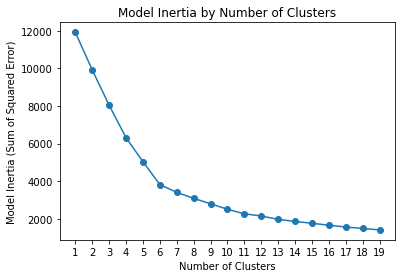

In [103]:
plt.plot(range(1,20), inertia, '-o')
plt.xticks(range(1,20), range(1,20))
plt.title('Model Inertia by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Model Inertia (Sum of Squared Error)')
plt.show()

In [104]:
#Though we can use our eyes to identify the "elbow", but we can use a python package to solve for the elbow
#Documentation: https://kneed.readthedocs.io/en/stable/

In [105]:
from kneed import KneeLocator

In [106]:
elbow = KneeLocator(range(1,20), inertia, curve='convex', direction='decreasing')
elbow.knee

6

In [107]:
#Lets plot the sihloutte scores as well

In [108]:
silhouette = []

for i in range(2,20):
    model = KMeans(n_clusters=i)
    preds = model.fit_predict(customer_norm)
    score = silhouette_score(customer_norm, preds)
    silhouette.append(score)

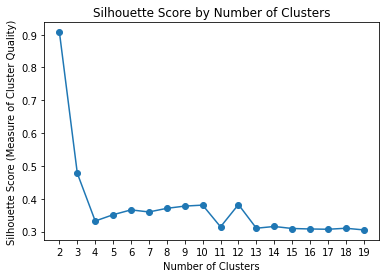

In [109]:
plt.plot(range(2,20), silhouette, '-o')
plt.xticks(range(2,20), range(2,20))
plt.title('Silhouette Score by Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score (Measure of Cluster Quality)')
plt.show()

In [111]:
list(zip(range(2,20), silhouette))

[(2, 0.9073971894336775),
 (3, 0.47741785933826925),
 (4, 0.3321954360319659),
 (5, 0.35138551170261717),
 (6, 0.36609796642505993),
 (7, 0.3597923290735237),
 (8, 0.37082093485797063),
 (9, 0.37762611667316814),
 (10, 0.3806573262818033),
 (11, 0.3144451986438551),
 (12, 0.3824041507076044),
 (13, 0.3102236373706061),
 (14, 0.3155610712225876),
 (15, 0.3093799030103964),
 (16, 0.30795411627131786),
 (17, 0.3070755687752629),
 (18, 0.31011064730681326),
 (19, 0.3050671411769065)]

In [112]:
#Elbow method tells us to use 6 clusters, which has a relatively decent score
#I was considering 10 clusters, but printing out the scores above, the difference between 6 and 10 is marginal
#I'd prefer maintaing 6 clusters as, based on the elbow method, this is the optimal number of clusters

In [113]:
#Lets get our 6 clusters

In [114]:
model = KMeans(n_clusters=6)

model.fit(customer_norm)

KMeans(n_clusters=6)

In [115]:
#Let's add the cluster number to our data

In [116]:
customer['cluster'] = model.labels_

In [117]:
customer.head()

,Customer ID,cancel_percent,avg_spend,total_orders,days_since_most_recent_order,cluster
0,12346.0,0.52381,21.7480,9.0,4865,2
1,12347.0,0.00000,38.2500,1.0,4740,0
2,12349.0,0.25000,17.5500,2.0,4743,2
3,12352.0,0.00000,12.7250,1.0,4711,0
4,12356.0,0.00000,75.7125,2.0,4716,0


# Exploring Our Clusters

In [118]:
#Now that we have our clusters, let's look at our features, broken out by cluster

In [119]:
#Let's first see the distribution of our clusters across our customers

In [123]:
customer['cluster'].value_counts(normalize=True)

5    0.364094
0    0.345638
1    0.215604
2    0.064597
4    0.008809
3    0.001258
Name: cluster, dtype: float64

In [125]:
#Let's graph each of our feature by cluster

In [139]:
clusters = customer.groupby('cluster')[['cancel_percent', 
                                        'avg_spend', 
                                        'total_orders',
                                       'days_since_most_recent_order']].mean().reset_index()

In [140]:
clusters

,cluster,cancel_percent,avg_spend,total_orders,days_since_most_recent_order
0,0,0.014511,34.722996,2.890777,4755.391990
1,1,0.004682,24.454814,1.336576,4956.593385
2,2,0.397710,115.358814,2.532468,4818.487013
3,3,0.644444,8177.006667,1.666667,4900.666667
4,4,0.098233,85.203593,37.095238,4714.904762
5,5,0.012275,23.661844,2.721198,4755.572581


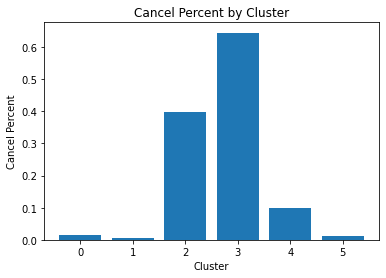

In [141]:
plt.bar(clusters['cluster'], clusters['cancel_percent'])
plt.title('Cancel Percent by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Cancel Percent')
plt.show()

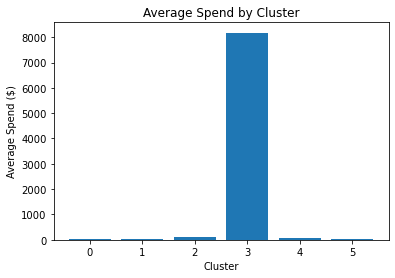

In [142]:
plt.bar(clusters['cluster'], clusters['avg_spend'])
plt.title('Average Spend by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Spend ($)')
plt.show()

In [133]:
#Cluster looks really high, might be that $10k manual from earlier

In [134]:
customer[customer['cluster'] == 3].head()

,Customer ID,cancel_percent,avg_spend,total_orders,days_since_most_recent_order,cluster
219,12918.0,0.666667,10953.50,1.0,4962,3
692,14063.0,0.666667,6619.35,2.0,4774,3
1383,15760.0,0.600000,6958.17,2.0,4966,3


In [136]:
df[df['Customer ID'] == '12918.0'].head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,is_cancel,Revenue
5775,C502262,M,Manual,0,2010-03-23 15:20:00,10953.5,12918.0,United Kingdom,1,0.0
5776,502263,M,Manual,1,2010-03-23 15:22:00,10953.5,12918.0,United Kingdom,0,10953.5
5777,C502264,M,Manual,0,2010-03-23 15:24:00,10953.5,12918.0,United Kingdom,1,0.0


In [143]:
#Cluster 3 is super odd, high cancel rates, high spend on 'manual'?

#Let's graph avg spend without cluster 3

In [147]:
cluster_no_3 = clusters.drop(clusters[clusters['cluster'] == 3].index)

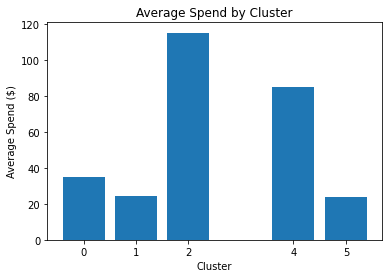

In [150]:
plt.bar(cluster_no_3['cluster'], cluster_no_3['avg_spend'])
plt.title('Average Spend by Cluster')
plt.xticks(cluster_no_3['cluster'].unique(), cluster_no_3['cluster'].unique())
plt.xlabel('Cluster')
plt.ylabel('Average Spend ($)')
plt.show()

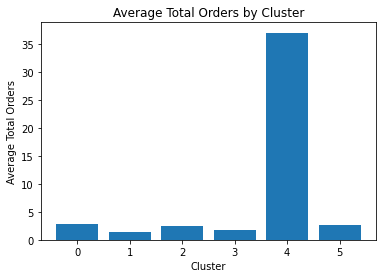

In [204]:
plt.bar(clusters['cluster'], clusters['total_orders'])
plt.title('Average Total Orders by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Total Orders')
plt.show()

In [205]:
#Cluster 4 is out ideal cluster, relatively high avg spend and total orders, with relatively low cancel rate

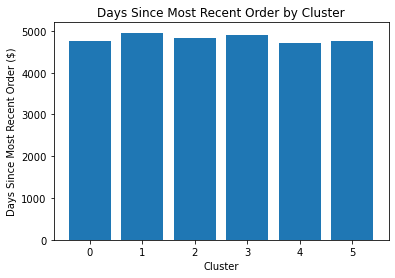

In [206]:
plt.bar(clusters['cluster'], clusters['days_since_most_recent_order'])
plt.title('Days Since Most Recent Order by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Days Since Most Recent Order ($)')
plt.show()

In [207]:
#Seems like each cluster, on avg, has similar "recency" for their orders

In [208]:
#Let's break down our clusters by country

In [216]:
country = df.drop_duplicates(subset='Customer ID')[['Customer ID', 'Country']].reset_index(drop=True)
country.head()

,Customer ID,Country
0,13078.0,United Kingdom
1,16393.0,United Kingdom
2,17998.0,United Kingdom
3,17611.0,United Kingdom
4,17345.0,United Kingdom


In [217]:
customer = customer.merge(country, on='Customer ID', how='left')

In [218]:
customer.head()

,Customer ID,cancel_percent,avg_spend,total_orders,days_since_most_recent_order,cluster,Country_x,Country_y,Country
0,12346.0,0.52381,21.7480,9.0,4865,2,United Kingdom,United Kingdom,United Kingdom
1,12347.0,0.00000,38.2500,1.0,4740,0,Iceland,Iceland,Iceland
2,12349.0,0.25000,17.5500,2.0,4743,2,Italy,Italy,Italy
3,12352.0,0.00000,12.7250,1.0,4711,0,Norway,Norway,Norway
4,12356.0,0.00000,75.7125,2.0,4716,0,Portugal,Portugal,Portugal


In [219]:
customer_count = customer.groupby(['Country', 'cluster']).size().unstack().fillna(0)

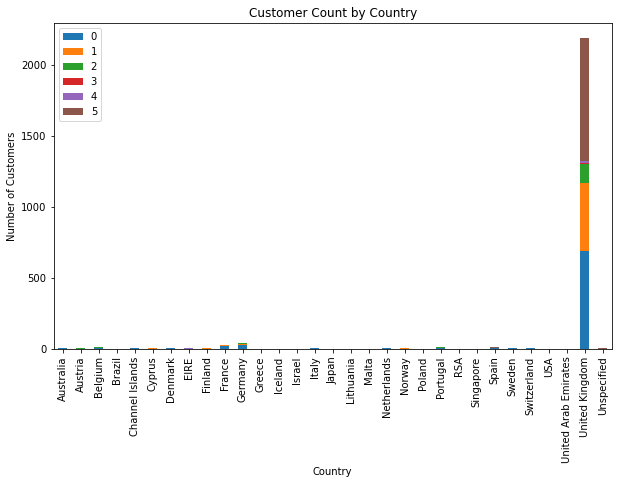

In [220]:
customer_count.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Customer Count by Country')
plt.ylabel('Number of Customers')
plt.legend(loc='best', prop={'size': 10})
# plt.tight_layout()
plt.show()

In [221]:
#Let's see w/o the UK

In [222]:
customer_no_uk = customer[customer['Country'] != 'United Kingdom']

In [223]:
customer_count = customer_no_uk.groupby(['Country', 'cluster']).size().unstack().fillna(0)

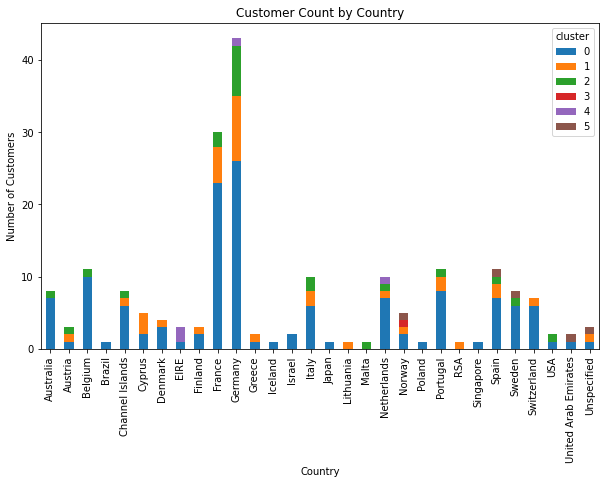

In [224]:
customer_count.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Customer Count by Country')
plt.ylabel('Number of Customers')
# plt.legend(loc='best', prop={'size': 10},
#           bbox_to_anchor=(1, 1), ncol=2)
# plt.tight_layout()
plt.show()

In [225]:
#Aside from the UK, most customers are coming from Germany and France
#Those in the UK are mainly from cluster 5, who have low spend (but low cancel and low cancel)
#Those from Germany and France are mainly cluster 0, who don't order nor spend much

In [227]:
#Let's breakdown what our 6 clusters are (in order of descending size):

#Cluster 5 and Cluster 0: Low Spending, Low Ordering customers who don't cancel
#Cluster 1: Low ordering customers with okay spend and low cancel rates
#Cluster 2 Customers who don't order, but when they do, they spend a lot, but have higher cancel rates
#Cluster 4: Customers who order a lot and spend a good amount, with low cancel rates
#Cluster 3: I think these are errors, they're "high spend" customers that mostly cancel. 
#This is based on these "manual" products that cost up to $10k

In [228]:
#Lastly, let's see where Cluster 4 customers live

In [238]:
cluster_4_count = customer[customer['cluster'] == 4]

cluster_4_count = pd.DataFrame(cluster_4_count['Country'].value_counts(normalize=True)).reset_index()

cluster_4_count.columns = ['Country', 'share_of_cluster']

cluster_4_count

,Country,share_of_cluster
0,United Kingdom,0.809524
1,EIRE,0.095238
2,Germany,0.047619
3,Netherlands,0.047619


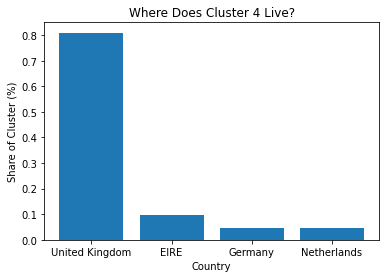

In [240]:
plt.bar(cluster_4_count['Country'], cluster_4_count['share_of_cluster'])
plt.ylabel('Share of Cluster (%)')
plt.xlabel('Country')
plt.title('Where Does Cluster 4 Live?')
plt.show()